# ML Model - Predict Tournament Finish

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* Given that this is a regression task and finishing positions are spread out evenly, we do not need to worry about target imbalance. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [4]:
import os
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [5]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [6]:
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics'

# Download Data and Scaling Pipeline

In [7]:
import pandas as pd

train_data = pd.read_csv("outputs/data/final/train/train_data.csv")
val_data   = pd.read_csv("outputs/data/final/validation/val_data.csv")
test_data  = pd.read_csv("outputs/data/final/test/test_data.csv")
train_data.head()

,player_id,tournament_id,finish_numeric,true_pos,top_ten,mid_band,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,9261,401353224,32.0,32.0,0,0,0.20,-0.13,-0.08,0.86,0.65,0.85
1,5548,401353224,18.0,18.0,0,1,0.36,0.75,0.31,0.18,1.24,1.60
2,4989,401353224,0.0,91.0,0,0,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,6015,401353224,0.0,91.0,0,0,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,3832,401353224,0.0,91.0,0,0,0.53,-0.36,-1.39,0.19,-1.56,-1.04


Split features and target for ML model

In [8]:
sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']


X_train = train_data[sg_features]
y_train = train_data['true_pos']

X_val = val_data[sg_features]
y_val = val_data['true_pos']

X_test = test_data[sg_features]
y_test = test_data['true_pos']

y_train.head()

0    32.0
1    18.0
2    91.0
3    91.0
4    91.0
Name: true_pos, dtype: float64

Download Scaling Pipeline.

In [9]:
import joblib
strokes_pipeline = joblib.load("outputs/pipelines/strokes_pipeline.pkl")

## Create the Model

## Random Forest Regressor

Initially, we will start with a Random Forest Regressor. Random Forests can capture nonlinear relationships quickly and effectively, unlike simple linear regression, which assumes a straight-line relationship. Since strokes gained data likely has complex, non-linear interactions, a Random Forest Regressor is a strong starting point for modeling tournament position. We also ahve to ensure sg_total and sg_t2g are not in the model as these are multi-disciplinary metrics and will skew the results.

Validation Metrics:
RMSE: 16.56
MAE: 11.11
R²: 0.74


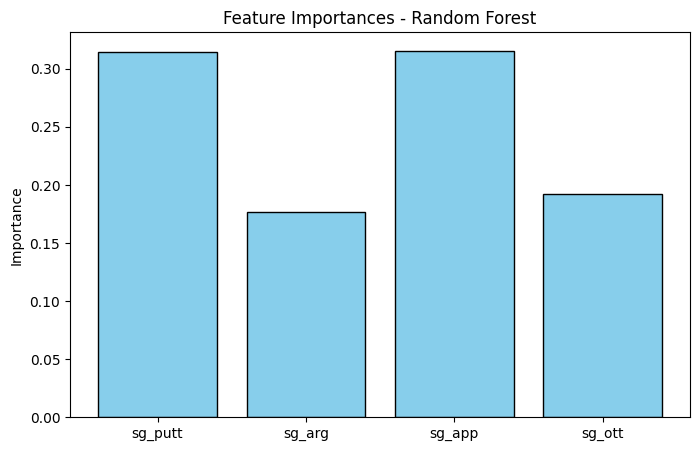

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']

X_train_subset = X_train[sg_features]
X_val_subset   = X_val[sg_features]
X_test_subset  = X_test[sg_features]

pipeline = Pipeline([
    ('scaler', strokes_pipeline),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train_subset, y_train)

y_val_pred = pipeline.predict(X_val_subset)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Validation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


model = pipeline.named_steps['model']
importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(sg_features, importances, color='skyblue', edgecolor='black')
plt.title("Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.show()


This feature importance graph verifies our findings that putting and approach play are the most important factors in a good tournament finishing position.

Next we will assess the ML model performance with a scatter plot.

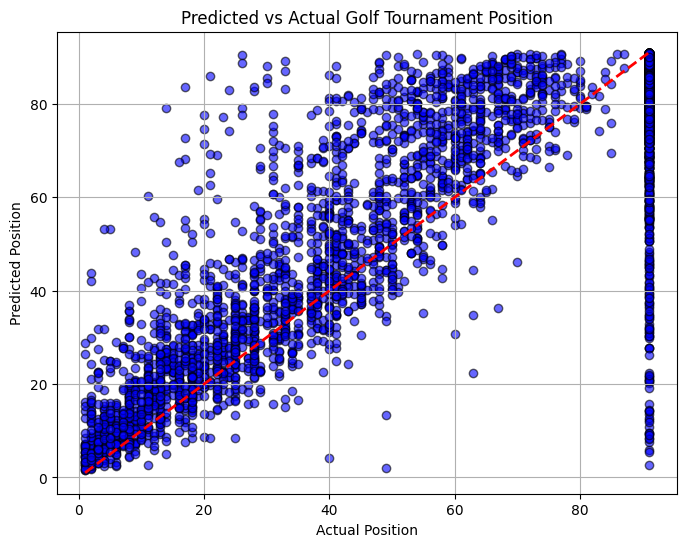

In [11]:
y_val_pred = pipeline.predict(X_val[sg_features])

plt.figure(figsize=(8,6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Predicted vs Actual Golf Tournament Position")
plt.grid(True)
plt.show()


This has identified that the model is in general overpredicting finishing position. It has also identified that there is still an issue with players who missed the cut (given a numeric value of 91). They are skewing the data and leading to the model overpredicting.
We will try the same model but without players who missed the cut.

Validation Metrics (positions < 90):
RMSE: 9.61
MAE: 7.04
R²: 0.81


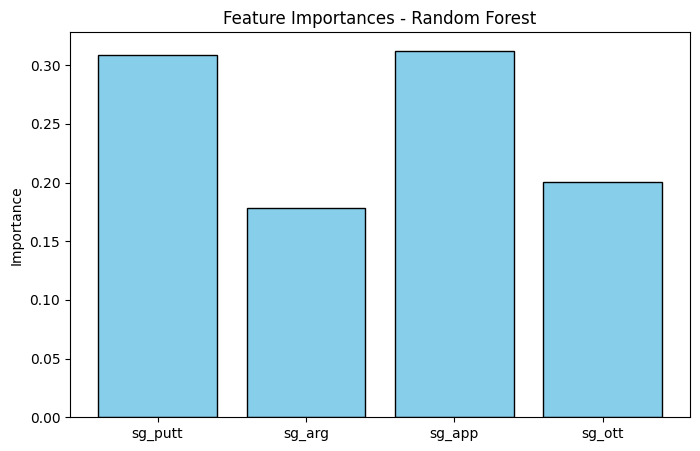

In [12]:
train_filtered = train_data[train_data['true_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['true_pos'] < 90].reset_index(drop=True)
test_filtered  = test_data[test_data['true_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']

X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['true_pos']

X_val_f = val_filtered[sg_features]
y_val_f = val_filtered['true_pos']

X_test_f = test_filtered[sg_features]
y_test_f = test_filtered['true_pos']


pipeline = Pipeline([
    ('scaler', strokes_pipeline),  # your existing scaling pipeline
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


pipeline.fit(X_train_f, y_train_f)

y_val_pred = pipeline.predict(X_val_f)

rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


model = pipeline.named_steps['model']
importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(sg_features, importances, color='skyblue', edgecolor='black')
plt.title("Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.show()


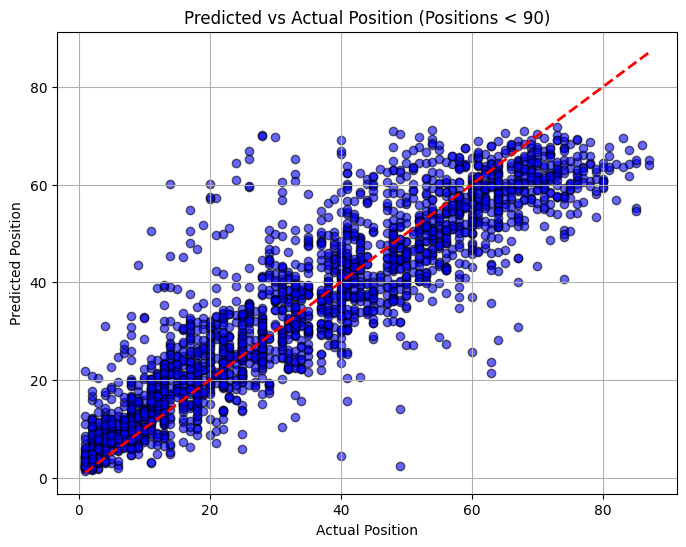

In [13]:
import matplotlib.pyplot as plt

y_val_pred = pipeline.predict(X_val_f)

plt.figure(figsize=(8,6))
plt.scatter(y_val_f, y_val_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([y_val_f.min(), y_val_f.max()], [y_val_f.min(), y_val_f.max()], 'r--', linewidth=2)  # perfect prediction line
plt.xlabel("Actual Position")
plt.ylabel("Predicted Position")
plt.title("Predicted vs Actual Position (Positions < 90)")
plt.grid(True)
plt.show()


The results here are better. This leads to a question of what to do about predicting missed cuts. As it is not a key business requirement for our client to predict players who miss the cut and they are hoping to target players with an 11th-30th place finish, we will proceed without using the cut data. As a standard golf tournament usualy has 70 players making the cut, in the final application we may well still be able to make a missed cut prediction if the numeric prediction is >70.

To check, we will try using the Random Forest Regressor but without the scaled strokes gained stats.

In [14]:
train_filtered = train_data[train_data['true_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['true_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']
X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['true_pos']
X_val_f   = val_filtered[sg_features]
y_val_f   = val_filtered['true_pos']

pipeline = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train_f, y_train_f)

y_val_pred = pipeline.predict(X_val_f)
rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90, no scaling):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

Validation Metrics (positions < 90, no scaling):
RMSE: 9.60
MAE: 7.04
R²: 0.81


The results are almost identical!

## Gradient Boosting
Gradient Boosting is a method that can capture nonlinear relationships to a high degree. It can often detect subtle interactions between features more effectively than a Random Forest, making it a good next step in creating the most accurate model.


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

train_filtered = train_data[train_data['true_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['true_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']
X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['true_pos']
X_val_f   = val_filtered[sg_features]
y_val_f   = val_filtered['true_pos']

gbr_model = GradientBoostingRegressor(
    n_estimators=200,    
    learning_rate=0.1,   
    max_depth=3,         
    random_state=42
)

gbr_model.fit(X_train_f, y_train_f)

y_val_pred = gbr_model.predict(X_val_f)

rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90, Gradient Boosting):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


Validation Metrics (positions < 90, Gradient Boosting):
RMSE: 9.60
MAE: 7.14
R²: 0.81


This performed slightly worse than the Random Forest. 

## XGBoost

For the final modl assessment we will try XGBoost, which can also capture nonlinear relationships and does not need feature scaling.

In [16]:
import xgboost as xgb

train_filtered = train_data[train_data['true_pos'] < 90].reset_index(drop=True)
val_filtered   = val_data[val_data['true_pos'] < 90].reset_index(drop=True)

sg_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']
X_train_f = train_filtered[sg_features]
y_train_f = train_filtered['true_pos']
X_val_f   = val_filtered[sg_features]
y_val_f   = val_filtered['true_pos']

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,     
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_f, y_train_f)

y_val_pred = xgb_model.predict(X_val_f)

rmse = np.sqrt(mean_squared_error(y_val_f, y_val_pred))
mae = mean_absolute_error(y_val_f, y_val_pred)
r2 = r2_score(y_val_f, y_val_pred)

print("Validation Metrics (positions < 90, XGBoost):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


Validation Metrics (positions < 90, XGBoost):
RMSE: 9.60
MAE: 7.10
R²: 0.81


## Model comparisons

| Model              | RMSE  | MAE  | R²   |
|---------------------|-------|------|------|
| **Random Forest**   | 9.61 | 7.04 | 0.81 |
| **Gradient Boosting** | 9.60 | 7.14 | 0.81 |
| **XGBoost**         | 9.60 | 7.10 | 0.81 |

All three models performed similarly, with minimal differences in predictive accuracy.  
Random Forest achieved the lowest MAE, though the margin is negligible.  
This indicates that the underlying relationships in the strokes gained data are being captured consistently across different tree-based algorithms.

As these results are slightly outside our targets (see readme) but similar in performance, we will fine-tune the hyperparameters of all of them to see which one results in the most improvement. 


## Hyperparamater Optimisation
Firstly, we wil create a custom class that runs GridSearchCV for each model and set of hyperparameters, then summarises the results in a table for easy comparison.

In [17]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimisationSearch:
    def __init__(self, models, params):
        """
        models: dict of sklearn pipelines or estimators, e.g., {"rf": pipeline}
        params: dict of hyperparameter grids, keys matching models
        """
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=True):
        """
        Fit GridSearchCV for all models provided.
        """
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key}...\n")
            
            model = self.models[key]
            param_grid = self.params[key]
            
            gs = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                scoring=scoring,
                refit=refit
            )
            
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Returns a DataFrame summarising cross-validation results for all models.
        """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params_list = self.grid_searches[k].cv_results_['params']
            splits = [f'split{i}_test_score' for i in range(self.grid_searches[k].cv)]
            for i, p in enumerate(params_list):
                scores = [self.grid_searches[k].cv_results_[split][i] for split in splits]
                rows.append(row(k, scores, p))

        df = pd.DataFrame(rows).sort_values([sort_by], ascending=False)
        return df, self.grid_searches


Next we will set up a quick hyperparamter search for the three regression models we have already looked at.

In [ ]:
models_quick_search = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, eval_metric='rmse')
}

params_quick_search = {
    "RandomForest": {},
    "GradientBoosting": {},
    "XGBoost": {}
}

## Random Forest Regressor

Next we will run the tests on our first model - Random Forest Regressor. As there was no difference with the strokes gained data scaled, we will not proceed with scaled data.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

models_rf = {
    "RandomForest": Pipeline([
        ('model', RandomForestRegressor(random_state=42))
    ])
}

params_rf = {
    "RandomForest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [3, 5, None]
    }
}

search = HyperparameterOptimisationSearch(models=models_rf, params=params_rf)

search.fit(
    X_train_f, 
    y_train_f,
    scoring='r2',
    n_jobs=-1,
    cv=5
)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary



Running GridSearchCV for RandomForest...

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,model__max_depth,model__n_estimators,estimator,min_score,max_score,mean_score,std_score
5,NaN,200,RandomForest,0.716886,0.847967,0.787126,0.048580
4,NaN,100,RandomForest,0.715217,0.847247,0.786033,0.048696
3,5.0,200,RandomForest,0.603295,0.709965,0.660745,0.038896
2,5.0,100,RandomForest,0.602522,0.708560,0.660738,0.038466
1,3.0,200,RandomForest,0.429861,0.503896,0.478194,0.026478
0,3.0,100,RandomForest,0.429431,0.501609,0.477790,0.025827


## Gradient Boosting

We will run the same checks for gradient boosting.

In [21]:
models_gbr = {
    "GradientBoosting": Pipeline([
        ('model', GradientBoostingRegressor(random_state=42))
    ])
}

params_gbr = {
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [2, 3, 4],
        "model__learning_rate": [0.05, 0.1, 0.2]
    }
}

search_gbr = HyperparameterOptimisationSearch(models=models_gbr, params=params_gbr)

search_gbr.fit(
    X_train_f, 
    y_train_f,
    scoring='r2',
    n_jobs=-1,
    cv=5
)

grid_search_summary_gbr, grid_search_pipelines_gbr = search_gbr.score_summary(sort_by='mean_score')
grid_search_summary_gbr



Running GridSearchCV for GradientBoosting...

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,model__learning_rate,model__max_depth,model__n_estimators,estimator,min_score,max_score,mean_score,std_score
8,0.05,4,300,GradientBoosting,0.712272,0.855333,0.792695,0.052969
7,0.05,4,200,GradientBoosting,0.711457,0.854697,0.792145,0.052422
15,0.10,4,100,GradientBoosting,0.712011,0.852868,0.791278,0.051494
16,0.10,4,200,GradientBoosting,0.711325,0.852076,0.790382,0.052008
17,0.10,4,300,GradientBoosting,0.711473,0.851041,0.789397,0.051622
5,0.05,3,300,GradientBoosting,0.701547,0.847891,0.785315,0.053597
24,0.20,4,100,GradientBoosting,0.705999,0.846085,0.785272,0.052199
14,0.10,3,300,GradientBoosting,0.704020,0.845280,0.784191,0.052826
13,0.10,3,200,GradientBoosting,0.701265,0.846533,0.784079,0.053565
4,0.05,3,200,GradientBoosting,0.698981,0.845603,0.783311,0.052858


## XG Boost
Finally, we will fine tune hyperparamaters for our last model - XG boost.

In [22]:
models_xgb = {
    "XGBoost": Pipeline([
        ('model', xgb.XGBRegressor(random_state=42))
    ])
}

# Define the hyperparameter grid
params_xgb = {
    "XGBoost": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [3, 4, 5],
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__subsample": [0.7, 0.8, 0.9],
        "model__colsample_bytree": [0.7, 0.8, 0.9]
    }
}

# Use your custom hyperparameter optimisation class
search_xgb = HyperparameterOptimisationSearch(models=models_xgb, params=params_xgb)

# Run the search on your training data
search_xgb.fit(
    X_train_f, 
    y_train_f,
    scoring='r2',  # regression scoring
    n_jobs=-1,
    cv=5
)

# Summarise results
grid_search_summary_xgb, grid_search_pipelines_xgb = search_xgb.score_summary(sort_by='mean_score')
grid_search_summary_xgb


Running GridSearchCV for XGBoost...

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,model__colsample_bytree,model__learning_rate,model__max_depth,model__n_estimators,model__subsample,estimator,min_score,max_score,mean_score,std_score
103,0.8,0.05,5,200,0.8,XGBoost,0.712708,0.859563,0.794674,0.053775
184,0.9,0.05,5,200,0.8,XGBoost,0.712708,0.859563,0.794674,0.053775
102,0.8,0.05,5,200,0.7,XGBoost,0.713183,0.858227,0.794628,0.053103
183,0.9,0.05,5,200,0.7,XGBoost,0.713183,0.858227,0.794628,0.053103
186,0.9,0.05,5,300,0.7,XGBoost,0.715539,0.856885,0.794368,0.052422
...,...,...,...,...,...,...,...,...,...,...
164,0.9,0.05,3,100,0.9,XGBoost,0.680050,0.802668,0.753920,0.043888
78,0.7,0.20,5,300,0.7,XGBoost,0.675450,0.805829,0.750487,0.050209
0,0.7,0.05,3,100,0.7,XGBoost,0.661484,0.785176,0.738483,0.043206
1,0.7,0.05,3,100,0.8,XGBoost,0.660143,0.784624,0.737759,0.043427


In [23]:
rf_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf_best.fit(X_train_f, y_train_f)
y_pred_rf = rf_best.predict(X_val_f)

gbr_best = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbr_best.fit(X_train_f, y_train_f)
y_pred_gbr = gbr_best.predict(X_val_f)

xgb_best = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_best.fit(X_train_f, y_train_f)
y_pred_xgb = xgb_best.predict(X_val_f)

def calc_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

results = {
    "Random Forest": calc_metrics(y_val_f, y_pred_rf),
    "Gradient Boosting": calc_metrics(y_val_f, y_pred_gbr),
    "XGBoost": calc_metrics(y_val_f, y_pred_xgb)
}

pd.DataFrame(results).T

,RMSE,MAE,R²
Random Forest,9.563533,7.001711,0.808630
Gradient Boosting,9.404845,6.866273,0.814928
XGBoost,9.400471,6.916770,0.815101


## Final hyperparamater fine tuning - XGBoost
As XGBoost has marginally performed the best, we will try and further refine the hyperparamters of this model.

In [24]:
# Define the model in a pipeline (no scaling needed)
models_xgb = {
    "XGBoost": Pipeline([
        ('model', xgb.XGBRegressor(random_state=42))
    ])
}

# Fine-tuning parameter grid
params_xgb = {
    "XGBoost": {
        "model__n_estimators": [200, 300, 400],       # number of trees
        "model__max_depth": [3, 4, 5],               # tree depth
        "model__learning_rate": [0.05, 0.1, 0.15],   # step size for updates
        "model__subsample": [0.7, 0.8, 0.9],         # fraction of rows per tree
        "model__colsample_bytree": [0.7, 0.8, 0.9]   # fraction of features per tree
    }
}

# Create the hyperparameter optimisation search
search_xgb = HyperparameterOptimisationSearch(models=models_xgb, params=params_xgb)

# Fit on your filtered training set
search_xgb.fit(
    X_train_f,
    y_train_f,
    scoring='r2',   # regression metric
    n_jobs=-1,
    cv=5
)

# Summarise results
grid_search_summary_xgb, grid_search_pipelines_xgb = search_xgb.score_summary(sort_by='mean_score')
grid_search_summary_xgb


Running GridSearchCV for XGBoost...

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,model__colsample_bytree,model__learning_rate,model__max_depth,model__n_estimators,model__subsample,estimator,min_score,max_score,mean_score,std_score
100,0.8,0.05,5,200,0.8,XGBoost,0.712708,0.859563,0.794674,0.053775
181,0.9,0.05,5,200,0.8,XGBoost,0.712708,0.859563,0.794674,0.053775
99,0.8,0.05,5,200,0.7,XGBoost,0.713183,0.858227,0.794628,0.053103
180,0.9,0.05,5,200,0.7,XGBoost,0.713183,0.858227,0.794628,0.053103
183,0.9,0.05,5,300,0.7,XGBoost,0.715539,0.856885,0.794368,0.052422
...,...,...,...,...,...,...,...,...,...,...
77,0.7,0.15,5,300,0.9,XGBoost,0.683870,0.821124,0.763389,0.052394
75,0.7,0.15,5,300,0.7,XGBoost,0.681236,0.822522,0.761676,0.053796
79,0.7,0.15,5,400,0.8,XGBoost,0.679493,0.817253,0.759345,0.052111
80,0.7,0.15,5,400,0.9,XGBoost,0.679473,0.814769,0.757745,0.052220


In [25]:
import pandas as pd
import numpy as np

# Round predictions to nearest integer
y_pred_rounded = np.rint(y_val_pred)

# Count how many times each position is predicted
position_counts = pd.Series(y_pred_rounded).value_counts().sort_index()
print(position_counts)

# Count top 3 predictions
top3_count = sum(position_counts.loc[1:3])
total_predictions = len(y_val_pred)
top3_percentage = top3_count / total_predictions * 100
print(f"Predicted top 3 finishes {top3_count} times ({top3_percentage:.2f}%)")


-11.0     1
-8.0      1
-6.0      4
-5.0      6
-4.0      4
         ..
 74.0    10
 75.0     4
 76.0     3
 77.0     2
 78.0     1
Name: count, Length: 87, dtype: int64
Predicted top 3 finishes 49 times (1.99%)


In [27]:
import pandas as pd
import numpy as np

# Round predictions to nearest integer and clip to valid positions (1–90)
y_pred_processed = np.rint(np.clip(y_val_pred, 1, 90))

# Count how many times each position is predicted
position_counts = pd.Series(y_pred_processed).value_counts().sort_index()
print(position_counts)

# Count top 3 predictions
top3_count = position_counts.loc[1:3].sum()
total_predictions = len(y_pred_processed)
top3_percentage = top3_count / total_predictions * 100
print(f"Predicted top 3 finishes {top3_count} times ({top3_percentage:.2f}%)")



1.0     81
2.0     16
3.0     15
4.0     21
5.0     26
        ..
74.0    10
75.0     4
76.0     3
77.0     2
78.0     1
Name: count, Length: 78, dtype: int64
Predicted top 3 finishes 112 times (4.54%)


In [31]:
import pandas as pd
import numpy as np

# Show more rows and columns
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

# Round and clip predictions
y_pred_rounded = np.rint(y_val_pred)
y_pred_clipped = np.clip(y_pred_rounded, 1, 90)

# Create DataFrame with predictions, actual positions, and strokes gained
pred_vs_actual = pd.DataFrame({
    'predicted_pos': y_pred_clipped,
    'true_pos': y_val_f.values,
    'sg_putt': X_val_f['sg_putt'].values,
    'sg_arg': X_val_f['sg_arg'].values,
    'sg_app': X_val_f['sg_app'].values,
    'sg_ott': X_val_f['sg_ott'].values
})

# Filter only 1st place predictions
first_place_preds = pred_vs_actual[pred_vs_actual['predicted_pos'] == 1]

# Reverse sort by true position (highest true_pos first)
first_place_preds_sorted = first_place_preds.sort_values('true_pos', ascending=False).reset_index(drop=True)

print(first_place_preds_sorted)


    predicted_pos  true_pos  sg_putt  sg_arg  sg_app  sg_ott
0             1.0      49.0     1.34    0.14    1.55    0.50
1             1.0      25.0     0.73    1.99    0.14    0.45
2             1.0      17.0     1.22    1.18   -0.04    1.21
3             1.0      14.0     0.57    1.39    0.84    0.20
4             1.0      11.0    -0.53    1.21    1.71    1.41
5             1.0      11.0     1.50    0.98    2.42    0.13
6             1.0       8.0     0.18    0.71    2.17    0.32
7             1.0       6.0     0.11    0.72    1.01    0.92
8             1.0       6.0     0.77    0.33    1.09    0.92
9             1.0       6.0     0.52    0.64    1.34    1.02
10            1.0       5.0     0.51    0.04    1.00    1.44
11            1.0       5.0     0.83    0.92    0.97    0.40
12            1.0       5.0     0.04    0.69    0.98    1.38
13            1.0       4.0    -0.06    0.39    1.65    1.08
14            1.0       4.0     0.69    0.76    1.05    0.58
15            1.0       

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Validation metrics using clipped predictions
rmse_clipped = np.sqrt(mean_squared_error(y_val_f, y_pred_clipped))
mae_clipped = mean_absolute_error(y_val_f, y_pred_clipped)
r2_clipped = r2_score(y_val_f, y_pred_clipped)

print("Validation Metrics (positions < 90, post-processed predictions):")
print(f"RMSE: {rmse_clipped:.2f}")
print(f"MAE: {mae_clipped:.2f}")
print(f"R²: {r2_clipped:.2f}")

# Count how many times each position is predicted
position_counts = pd.Series(y_pred_clipped).value_counts().sort_index()
print("\nPrediction counts by finishing position:")
print(position_counts)

# Count top 3 predictions
top3_count = sum(position_counts.loc[1:3])
total_predictions = len(y_pred_clipped)
top3_percentage = top3_count / total_predictions * 100
print(f"\nPredicted top 3 finishes {top3_count} times ({top3_percentage:.2f}%)")


Validation Metrics (positions < 90, post-processed predictions):
RMSE: 9.58
MAE: 7.02
R²: 0.81

Prediction counts by finishing position:
1.0     81
2.0     16
3.0     15
4.0     21
5.0     26
6.0     24
7.0     25
8.0     34
9.0     25
10.0    29
11.0    23
12.0    41
13.0    34
14.0    30
15.0    34
16.0    35
17.0    39
18.0    27
19.0    43
20.0    45
21.0    33
22.0    40
23.0    46
24.0    42
25.0    39
26.0    47
27.0    34
28.0    53
29.0    49
30.0    47
31.0    32
32.0    42
33.0    49
34.0    45
35.0    46
36.0    29
37.0    40
38.0    37
39.0    38
40.0    35
41.0    45
42.0    50
43.0    41
44.0    48
45.0    49
46.0    33
47.0    29
48.0    40
49.0    38
50.0    36
51.0    38
52.0    28
53.0    31
54.0    35
55.0    26
56.0    23
57.0    32
58.0    29
59.0    35
60.0    27
61.0    24
62.0    30
63.0    24
64.0    19
65.0    20
66.0    22
67.0    29
68.0    17
69.0    22
70.0    17
71.0    15
72.0    14
73.0    10
74.0    10
75.0     4
76.0     3
77.0     2
78.0     1
Name:

In [36]:
# Filter predictions above 90
over_90_preds = pred_vs_actual[pred_vs_actual['predicted_pos'] > 75]

# Show them
print(over_90_preds)


      predicted_pos  true_pos  sg_putt  sg_arg  sg_app  sg_ott
372            76.0      67.0    -2.00   -1.01   -0.35   -0.02
444            76.0      67.0    -0.40   -0.24   -0.33   -1.18
1228           78.0      78.0     0.12   -0.47   -0.33   -1.42
1317           76.0      30.0    -0.87   -0.58   -1.06   -0.59
1985           77.0      68.0    -0.36   -0.88   -1.06   -0.18
2231           77.0      72.0    -0.34   -0.97   -1.23   -0.23
